# Is Deep Learning Hype? Sentiment Analysis Comparing Deep Learning and Non-Deep Learning Methods

### Problem Statement

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which can be very misleading for both humans and computers alike. Moreover, most of the growth in data being generated globally is unstructured in nature, such as emails, videos, texts and social media messages. As a result, companies and enterprises are looking to new ways of making sense of all this data. This analysis aims to provide a few tools to make sense of text data. 

### Executive Summary

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; This analysis uses various Natural Language Processing (NLP) tools to analyze sentiment in Internet Movie Database (IMDB) reviews. First, the data is cleaned and preprocessed, followed by some Exploratory Data Analysis (EDA). Then, various techniques are used to compare deep learning and non-deep learning methods. The final production model is then tested by submitting the results to a Kaggle competition, producing an accuracy score of 85.7%. A final conclusion wraps up with lessons learned and plans for future analyses. 

### Data Cleaning and Preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The labeled data set consists of 50,000 IMDB movie reviews. The sentiment is coded as a binary variable, where a rating less than five results in a sentiment score of zero, and ratings greater than or equal to 7 have a sentiment score of 1. All movies have less than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews without any rating labels against which my various models are tested.

First, I used BeautifulSoup to remove HTML from the reviews. I then used RegEx to remove all non-letters and change them all to lowercase. I then split each review by words, removing stopwords, and joining them back together into a paragraph as one unified review again. For some of the models, I left the stopwords in, because some of the tools had their own built-in methods for dealing with stopwords.

For my sentences, I used NLTK's punkt tokenizer for sentence splitting. I created a custom function that split the reviews into parsed sentences. I pickled these sentences to be used for later analyses. This dataset was collected in association with the following publication:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "Learning Word Vectors for Sentiment Analysis." The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

### Exploratory Data Analysis

Loading in the previously cleaned review data

In [4]:
import pandas as pd
train_df = pd.read_csv('../data/cleantrain.csv')

Engineering new features to show the length of each review (by character and by word)

In [5]:
train_df['char_count'] = train_df.cleanreview.map(len)
train_df['word_count'] = train_df.cleanreview.map(lambda x: len(x.split()))

In [6]:
train_df.char_count.groupby(train_df.sentiment).mean()

sentiment
0    1240.28048
1    1286.20992
Name: char_count, dtype: float64

In [7]:
train_df.word_count.groupby(train_df.sentiment).mean()

sentiment
0    234.05440
1    239.56944
Name: word_count, dtype: float64

As we can see, it seems like the average word and character counts for reviews is slightly higher for positive reviews. Below are some visualizations of these distributions.

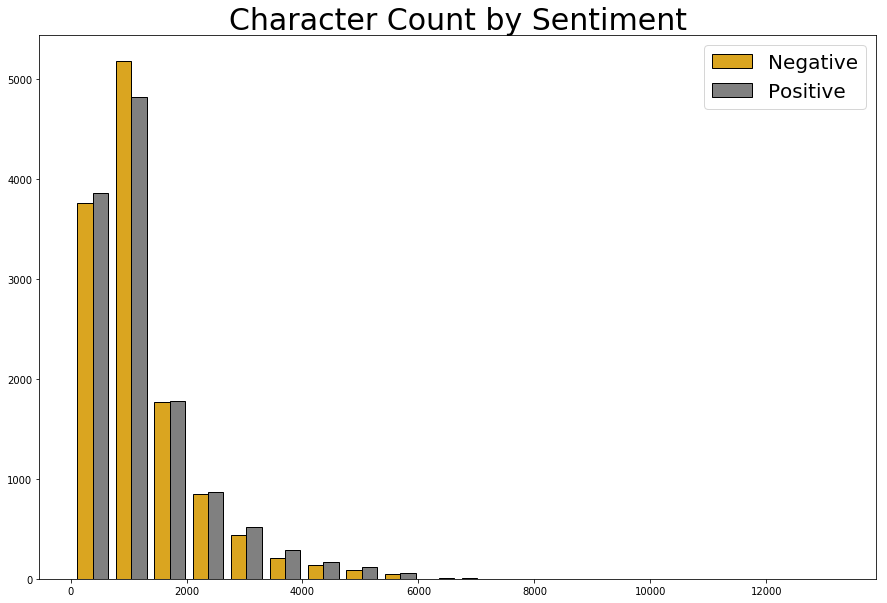

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,10))
plt.hist([train_df[train_df['sentiment']==0]['char_count'], 
          train_df[train_df['sentiment']==1]['char_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Character Count by Sentiment', fontsize=30)
plt.legend(['Negative', 'Positive'], fontsize=20);

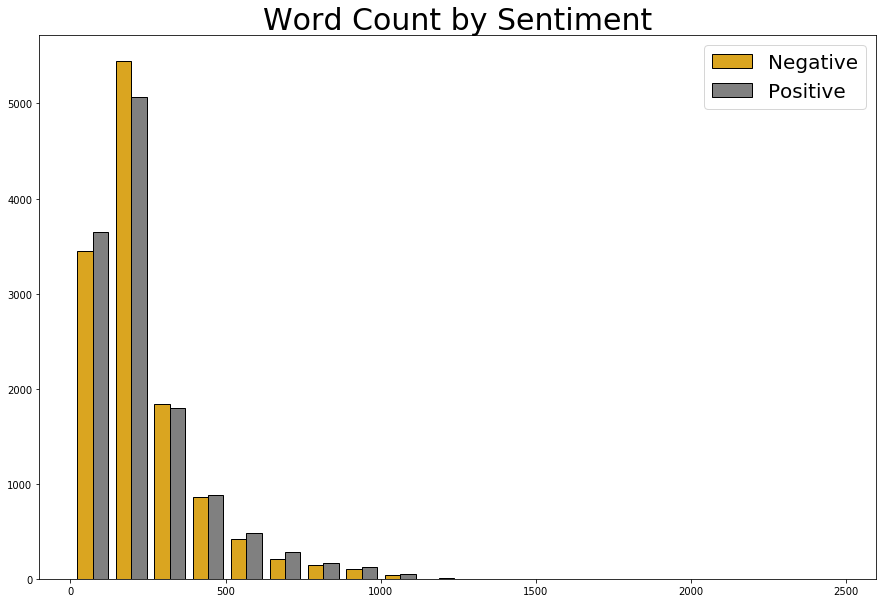

In [10]:
plt.figure(figsize=(15,10))
plt.hist([train_df[train_df['sentiment']==0]['word_count'], 
          train_df[train_df['sentiment']==1]['word_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Word Count by Sentiment', fontsize=30)
plt.legend(['Negative', 'Positive'], fontsize=20);

Interestingly, both sentiments are similarly skewed to the right, with the vast majority of reviews having less than 500 words. The most verbose review had almost 2500 words, and of course it was positive. The longest negative review only had 1539 words. 

Next, I use CountVectorizer to turn these reviews into a matrix of vectors for the count of each word (i.e. take all the words in the reviews and create columns of them containing the word's prevalence, or frequency count). However, there are many words that will essentially get counted more than once, because they are different forms of the same word (e.g. plurals). Thus, I need to "lemmatize" these words to keep only their base forms (e.g. singular instead of plural). 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

After instantiating the Lemmatizer above, I add a new column in the train dataframe for the lemmatized reviews. 

In [13]:
train_df['lemmatized_review'] = train_df.cleanreview.map(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x.split()]))

I eliminate stop words and specify the minimum document frequency to be half a percent. This means that all words that are not used in at least .5% of all reviews will be ignored. Otherwise, we would end up with 73,830 "words," many of which would not be actual words, but typos or nonsense strings of characters.

In [14]:
cvec = CountVectorizer(stop_words='english', min_df=.005)

In [16]:
word_matrix = cvec.fit_transform(train_df.lemmatized_review)

In [17]:
len(cvec.get_feature_names())

2777

After setting the minimum threshold of .005, and lemmatizing the reviews, we are left with 2777 words. Now I will turn this into a dataframe to be able to see which of our words are most commonly used.

In [18]:
word_df = pd.DataFrame(word_matrix.toarray(), columns=cvec.get_feature_names())
word_df.insert(0, "sentiment", train_df.sentiment)

Putting sentiment back into the dataframe, to see if there are differences in the most commonly used words depending on sentiment.

In [19]:
word_df.groupby('sentiment').mean().T.sort_values(1, ascending=False).head(20)

sentiment,0,1
film,1.78312,1.97952
movie,2.32296,1.81248
wa,2.10288,1.75336
like,0.91760,0.74160
ha,0.61864,0.73920
time,0.60904,0.66768
good,0.59480,0.62096
story,0.45496,0.59824
just,0.84920,0.57216
character,0.56832,0.56584


As we can see, there are some differences in the prevalence of the top 20 words that are meaningful, such as "great," or "best," being much more common in positive reviews, which is to be expected. One interesting finding that was unexpected is that "film" is more common in positive reviews, as opposed to movie, which is the opposite. I suppose the word film has a slightly positive connotation to it, since historically movies were produced on actual film. Thus, someone could use it positively to describe an "artistic film," or a "classic film," etc., as opposed to "just another movie." 

In [20]:
sentiment_df = word_df.groupby('sentiment').sum().T.sort_values(1, ascending=False)
sentiment_df['diff'] = sentiment_df[1] - sentiment_df[0]
sentiment_df['diff'].sort_values().head(10)

movie    -6381
bad      -5486
wa       -4369
just     -3463
worst    -2226
like     -2200
don      -1879
plot     -1752
acting   -1621
minute   -1475
Name: diff, dtype: int64

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; As we can see, some of the top 10 biggest differences in word usage between positive and negative reviews are unsurprising. "Bad" appeared 5486 times more in negative reviews than positive ones, which makes sense; same thing with "worst." As mentioned above, indeed the biggest difference in usage is the word "movie." From anecdotal evidence of personally browsing through some of the negative reviews, I found that the phrase, "just a bad movie" was quite common.

### Modeling

In [23]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(word_df.drop('sentiment', axis=1),
                                                    word_df.sentiment, random_state=42)

#### Non-Deep Learning Methods

* Logistic Regression

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I started off with non-deep learning methods to set some benchmarks against which to compare deep learning methods. I started off with a simple Logistic Regression model, and after some minor hyperparameter tuning, achieved an accuracy score of 92.7% on the training set and 86.2% on the test set. 

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000, C=.3)
lr.fit(X_train, y_train)
print("Logistic Regression score on the training set:", lr.score(X_train, y_train))
print("Logistic Regression score on the test set:", lr.score(X_test, y_test))

Logistic Regression score on the training set: 0.9272533333333334
Logistic Regression score on the test set: 0.86192


* $K$-Nearest Neighbors

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I then tried a KNearestNeighbors Classifier model, which took by far the longest of all my models to run, so I will not put the code here. It achieved an accuracy score of 75.8% on the training set and 62.4% on the test set.

* Naive Bayes Classifier

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Next, I tested out a Naive Bayes Multinomial Classifier, which is suitable for text classification based on word counts. It scored 84.6% on the training set and 83.9% on the test set.

In [29]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
print("Naive Bayes score on the training set:", mnb.score(X_train, y_train))
print("Naive Bayes score on the test set:", mnb.score(X_test, y_test))

Naive Bayes score on the training set: 0.84624
Naive Bayes score on the test set: 0.83952


* Random Forests

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Finally, I tried a Random Forests Classifier model, which overfit on the training set and got 100% accuracy, but only got 83.7% on the test set.

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("Random Forests score on the training set:", rf.score(X_train, y_train))
print("Random Forests score on the test set:", rf.score(X_test, y_test))

Random Forests score on the training set: 1.0
Random Forests score on the test set: 0.82864


#### Deep Learning Methods

* Word2Vec

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; My first deep learning method used Google's Word2Vec to be able to use sentences, in the hopes that some context would be retained from the word order. It was a much more involved process, so I will not recreate the code here, but it can be found in the Word2Vec modeling notebook. 

To summarize, I created a vector space of 300 features with a minimum word count of 40 words per sentence and a context window of 10 words (i.e. to look at the preceding and following 10 words for any given word). Since each word is a vector in a 300-dimensional space, I averaged the word vectors in a given review before training a classifier. Using these feature vectors, I trained both Random Forests and Logistic Regression classifiers. The Random Forests again overfit on the training data, producing 100% accuracy on the training set. On the test set, the score was 83.5%, which was only slightly worse than the bag of words model above. Logistic Regression fared slightly better, scoring 85.5% on the training set and 85.8% on the test set. 

* Clustering or "Bag of Centroids"

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I expanded upon the previous model by using clustering to create a bag of centroids, instead of a bag of words. It is similar to bag of words, but uses clusters instead of just words. Unfortunately, it did not perform better. 

* Long Short-Term Memory Neural Network

For my final deep learning method, I used Keras to run a Long Short-Term Memory (LSTM) Neural Network model. Unlike the previous two, I had to tokenize the cleaned reviews again, using Keras' built-in tokenizer, limiting my maximum number of words to the top 6000. I then using Keras' padding functionality to pad my sentences by 240 words, which was the average length of my reviews. I then added an embedding layer that took my 6000 words as 1 neuron each and output only 128 neurons. I then took those 128 neurons and processed them through a bidirectional LSTM layer, followed by a pooling layer. Then, I added a dense layer with 20 neurons with an ReLU activation function. This was followed by a dropout layer with a 5% dropout rate. Finally, my output layer had only 1 neuron, with a sigmoid activation function which is appropriate for binary classification. 

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
import re, pickle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, confusion_matrix
from bs4 import BeautifulSoup

In [32]:
train_df = pd.read_csv('../data/cleantrain.csv')

In [33]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(train_df.cleanreview)
list_tokenized_train = tokenizer.texts_to_sequences(train_df.cleanreview)
X_train = pad_sequences(list_tokenized_train, maxlen=240)
y = train_df.sentiment

In [35]:
model = Sequential()
model.add(Embedding(input_dim=6000, output_dim=128))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [36]:
model.fit(X_train, y, batch_size=64, epochs=5, validation_split=.25)

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 71s 4ms/step - loss: 0.4774 - acc: 0.7660 - val_loss: 0.3589 - val_acc: 0.8448
Epoch 2/5
18750/18750 [==============================] - 70s 4ms/step - loss: 0.2654 - acc: 0.8920 - val_loss: 0.3010 - val_acc: 0.8739
Epoch 3/5
18750/18750 [==============================] - 68s 4ms/step - loss: 0.1866 - acc: 0.9314 - val_loss: 0.3188 - val_acc: 0.8749
Epoch 4/5
18750/18750 [==============================] - 69s 4ms/step - loss: 0.1353 - acc: 0.9551 - val_loss: 0.3536 - val_acc: 0.8706
Epoch 5/5
18750/18750 [==============================] - 72s 4ms/step - loss: 0.0888 - acc: 0.9719 - val_loss: 0.4396 - val_acc: 0.8590


In [43]:
test_df = pd.read_csv('../data/testData.tsv', header=0, delimiter='\t', quoting=3)

In [44]:
def review_to_wordlist(review, remove_stopwords=False):
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    # 5. Return the list of words as a paragraph by joining them together
    return(" ".join(words))

In [45]:
lemmatizer = WordNetLemmatizer()
test_df.review = test_df.review.apply(lambda x: review_to_wordlist(x))
test_df['sentiment'] = test_df['id'].map(lambda x: 1 if int(x.strip('"').split('_')[1]) >= 7 else 0)

In [46]:
y_test = test_df.sentiment
list_tokenized_test = tokenizer.texts_to_sequences(test_df.review)
X_test = pad_sequences(list_tokenized_test, maxlen=240)
prediction = model.predict(X_test)
y_pred = (prediction > .5)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))

F1-score: 0.8469242968032719


In [47]:
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

Confusion matrix:


array([[11185,  2353],
       [ 1315, 10147]])

### Conclusion and Future Steps

While the final production model utilizing deep learning performed slightly worse than the non-deep learning methods, the difference was negligible (just over one percent). I believe the biggest reason for this is the scale of the data. 25,000 examples to train on is pretty small for a neural network. In the future, I would like to train Word2Vec and my LSTM model with a lot more text, as deep learning generally requires massive amounts of data to improve performance. Google's state-of-the-art results with similar techniques are based on a corpus of more than a billion words. I would also like to try some newer tools that have only recently been developed, such as Sent2Vec and Doc2Vec, which utilize paragraph embeddings and other advanced techniques to better learn context and the meaning of words. 

Ultimately, is deep learning hype? Well, that depends on the scale of your data. If you are working with small datasets, traditional methods will likely be faster, and in some cases, more accurate (not to mention more interpretable). However, big data is the future, and the flexibility of neural networks makes them poised to be evermore important for data science as we generate more and more data. 